# Определение возраста покупателей

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей.

Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

**Цель**

Построить и обучить модель, которая по фотографии определит приблизительный возраст человека.

**Задача**

Добиться значения MAE на тестовой выборке не больше 8.

In [1]:
from PIL import Image
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
PATH = '/datasets/faces/'
RANDOM_STATE = 12345

plt.rcParams['figure.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['font.size'] = 14

## Исследовательский анализ данных

In [3]:
# загрузка датафрейма с таргетом
labels = pd.read_csv(PATH+'labels.csv')
print(labels.info())
display(labels.head())
print(f'Уникальные записи: \n{labels.nunique()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Уникальные записи: 
file_name    7591
real_age       97
dtype: int64


Данные содержат записи с названиями файлов и возрастом людей на фотографиях. 

Имеется 7591 запись с фотографиями людей разного возраста (97 разных возрастов).

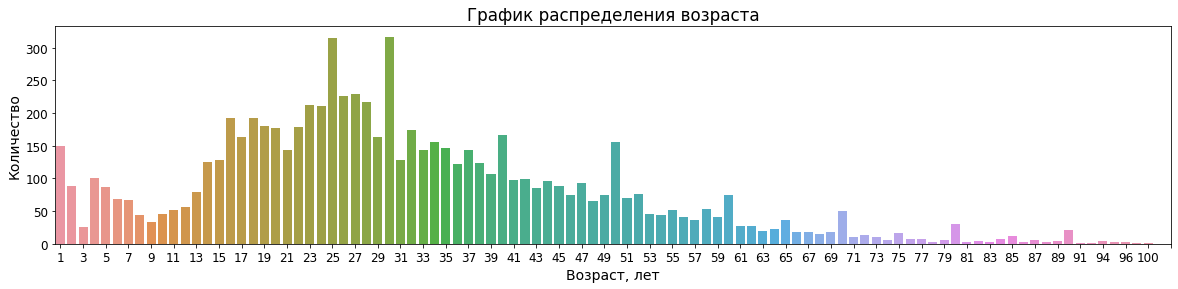

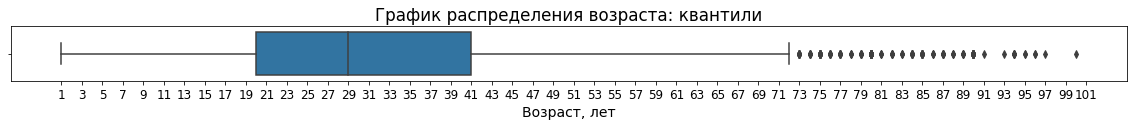

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


In [4]:
# построим распределение возраста людей
plt.figure(figsize=(20,4))
sns.countplot(data=labels, x='real_age', )
plt.title('График распределения возраста')
plt.xticks(range(0,100,2))
plt.xlabel('Возраст, лет')
plt.ylabel('Количество')
plt.show()

# распределение квантилями
plt.figure(figsize=(20,1), )
sns.boxplot(data=labels, x='real_age',)
plt.title('График распределения возраста: квантили')
plt.xticks(range(1,103, 2))
plt.xlabel('Возраст, лет')
plt.show()

# статистика возраста
display(labels["real_age"].describe().to_frame().T)

1. Данные содержат фотографии людей в возрасте от 1 года до 100 лет.
2. Средний возраст людей равен 17 годам, а медианное значение возрасто равно 29 годам, что говорит о том, что распределение смещено влево (видно на графике).
3. Q1–Q3 находится в диапазоне 20 – 41 года. это означает то, что модель лучше будет определять возраст людей в этой возрастной категории.
4. Наблюдается правый хвост после 72 лет, что может быть обусловлено тем, что средняя продолжительность жизни людей составляет ~ 73 года.
5. Наблюдается сильно выбивающиеся из общей картины пики: 25, 30, 40, 50 и т.д. лет. Такая картина указывает на то, что возраст некоторых людей мог быть округлен.

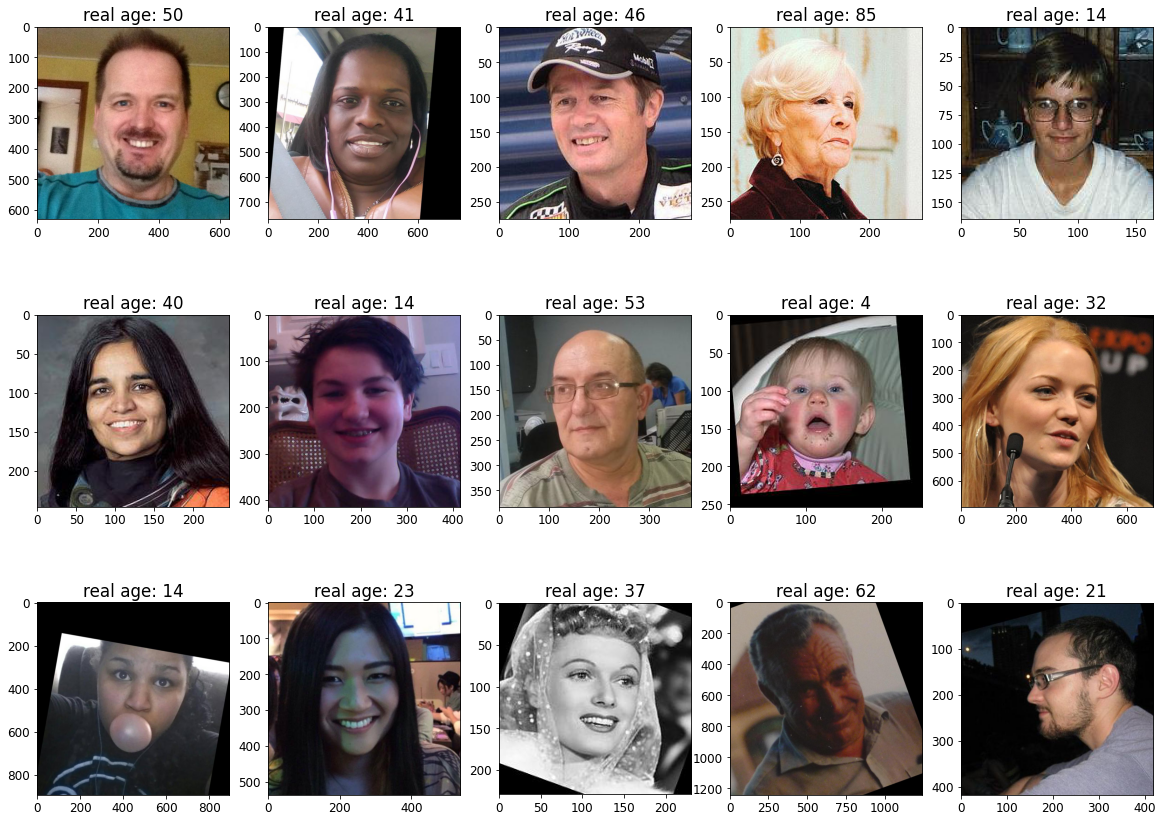

In [37]:
# выведем фотографии и возраст людей на них
samples = labels.sample(15, random_state=RANDOM_STATE)

fig, axs = plt.subplots(3,5, figsize=(20,15))
plt.subplots_adjust(hspace=0.2, wspace=0.2)
j=0
for i,k in zip(samples.file_name,samples.real_age):
    l = j // 5
    m = j % 5
    image = Image.open('/datasets/faces/final_files/'+i)
    array = np.array(image)
    img = axs[l,m].imshow(array)
    axs[l,m].set_title('real age: {:.0f}'.format(k))
    j += 1

1. Среди данных много повернутых изображений.
2. Встречаются изображения с низкой яркостью.
4. Имеются изображения в градациях серого.

<font size="4"><b>Промежуточные выводы</b></font>

1. Имеется достаточное количество данных, чтобы не замораживать верхушку ResNet50.
2. Половина данных содержит изображения людей возрастом от 20 до 41 года.
3. Для лучшего предсказания на тренировочной выборке стоит аугментировать данные: поворотом; уменьшением и увеличением яркости изображений. Также стоит добавить горизонтальное отражение.

## Обучение модели

Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке.

```python
import pandas as pd
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_train(path):
    '''
    Загрузка ТРЕНИРОВОЧНЫХ данных
    '''
    labels = pd.read_csv(path+'labels.csv')
    
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
#         отражение по горизонтали
        horizontal_flip=True,
#         поворот изображений по часовой 
        rotation_range=15,
#         понижение и повышение яркости изображений
        brightness_range=(0.6, 1.4), 
        rescale=1./255.)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow
    
def load_test(path):
    '''
    Загрузка ТЕСТОВЫХ данных
    '''
    labels = pd.read_csv(path+'labels.csv')
    
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255.)

    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_datagen_flow
    
def create_model(input_shape):
    '''
    СОЗДАНИЕ модели 
    '''
    backbone = ResNet50(
        input_shape=(224, 224, 3),
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=.0001)
    model.compile(optimizer=optimizer, 
        loss='mean_squared_error',
        metrics=['mae']) 

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=15,
                steps_per_epoch=None, validation_steps=None):
    '''
    ОБУЧЕНИЕ модели
    '''
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size, epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2)

    return model

```

Ниже приведен вывод модели во время обучения.

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 178 steps, validate for 60 steps
Epoch 1/15
178/178 - 139s - loss: 260.4844 - mae: 11.5280 - val_loss: 958.8114 - val_mae: 26.2036
Epoch 2/15
178/178 - 129s - loss: 90.1817 - mae: 7.1739 - val_loss: 435.4385 - val_mae: 15.6145
Epoch 3/15
178/178 - 133s - loss: 70.2634 - mae: 6.4202 - val_loss: 207.1859 - val_mae: 10.8191
Epoch 4/15
178/178 - 133s - loss: 55.3712 - mae: 5.7260 - val_loss: 100.9508 - val_mae: 7.6667
Epoch 5/15
178/178 - 117s - loss: 44.1674 - mae: 5.1240 - val_loss: 79.2374 - val_mae: 6.6681
Epoch 6/15
178/178 - 114s - loss: 40.1067 - mae: 4.8619 - val_loss: 71.8018 - val_mae: 6.3235
Epoch 7/15
178/178 - 113s - loss: 32.0603 - mae: 4.3756 - val_loss: 75.3777 - val_mae: 6.5440
Epoch 8/15
178/178 - 113s - loss: 29.1412 - mae: 4.1328 - val_loss: 70.1643 - val_mae: 6.2768
Epoch 9/15
178/178 - 113s - loss: 25.0955 - mae: 3.8677 - val_loss: 85.8652 - val_mae: 6.7753
Epoch 10/15
178/178 - 113s - loss: 23.5828 - mae: 3.7577 - val_loss: 67.0585 - val_mae: 6.1442
Epoch 11/15
178/178 - 113s - loss: 21.8679 - mae: 3.5910 - val_loss: 69.1964 - val_mae: 6.2440
Epoch 12/15
178/178 - 114s - loss: 18.6857 - mae: 3.3218 - val_loss: 73.4038 - val_mae: 6.6046
Epoch 13/15
178/178 - 118s - loss: 16.6130 - mae: 3.1056 - val_loss: 61.9699 - val_mae: 5.9021
Epoch 14/15
178/178 - 126s - loss: 14.9762 - mae: 2.9861 - val_loss: 63.3928 - val_mae: 5.8699
Epoch 15/15
178/178 - 131s - loss: 14.5806 - mae: 2.9150 - val_loss: 62.6221 - val_mae: 5.8181

60/60 - 12s - loss: 62.6221 - mae: 5.8181
```

## Анализ обученной модели

Перед нами стояла задача построить и обучить модель, которая сможет определять возраст человека по изображению со средним абсолютным отклонением ***MAE не выше 8***.

1. `Подготовка данных`

В нашем распоряжении был датасет с **7591** размеченными изображениями, среди которых часто встречаются изображения повернутые по часовой и против часовой, часть изображений выполнены при слабом освещении, некоторые слишком яркие.

* Предварительно **75% данных были отделены для тренировки** модели. Для того, чтобы модель обучилась точнее, тренировочные данные *аугментировали для расширения датасета: поворот по часовой, изменение яркости изображений, отражение по горизонтали*.

* Оставшиеся **25% не подвергали изменениям для тестирования** модели.

2. `Настройка модели`

В качестве основы модели была взята предобученная нейросеть с архитектурой **`ResNet50`**, которую дообучили тренировочных данных.

В выходном слое, для более точного обучения модели, использовали оптимизацию **`Adam`** c шагом обучения **0.0001**. В качестве метрики использовали ср.абсолютное отклонение, а в качестве функции потерь использовалась среднеквадратичную ошибку (`mean squared error`), чтобы ускорить процесс обучения.

3. `Результаты обучения модели`

Модель обучали на 15 эпохах. После обучения на 4 эпохах, модель выдала значение метрики MAE 7.6667 на тестовой выборке, что уже соотвествует задаче — MAE не больше 8.

Начиная с 7 по 12 эпохи обучения модели наблюдались скачки (рост) потерь на тестовых данных, однако, не смотря на это на 15 эпохе значение MAE улучшилось и равнялось 5.8181, то есть модель успешно продолжала обучение без переобучения под тренировочную выборку.

4. `Итоговые выводы`

Успешно обучена модель, которая определяет возраст людей по фотографии. 
* Для достижения наибольшей точности рекомендуется использовать модель, обученную на 15 эпохах.
* Для сокращения времени обучения модели рекомендуется использовать модель, обученную на 4 эпохах.